# Image Caption Generator

The purpose of this notebook is to extract features from images using the pretrained VGG16 model, and feed these features to the LSTM model with the captions to train. This model will then be able to predict captions for any image based on the image features.

**Data:**    
The COCO (Common Objects in Context) 2017 dataset was used, and can be found by following the link: http://cocodataset.org/#download. This is a very large dataset, so the code took quite a long time to run.

## 1. Import packages

In [53]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from PIL import Image
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
import json
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import time

python 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
keras version 2.3.1
tensorflow version 1.14.0


In [2]:
def set_seed(sd=144):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    
    ## numpy random seed
    seed(sd)
    
    ## core python's random number 
    rn.seed(sd)
    
    ## tensor flow's random number
    set_random_seed(sd)

## 2. Importing the image dataset and accompanying captions

In [3]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2017.json'

name_of_zip = 'train2017.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
    image_zip = tf.keras.utils.get_file(name_of_zip,
                                        cache_subdir=os.path.abspath('.'),
                                        origin = 'http://images.cocodataset.org/zips/train2017.zip',
                                        extract = True)
    PATH = os.path.dirname(image_zip)+'/train2017/'
else:
    PATH = os.path.abspath('.')+'/train2017/'

In [4]:
jpgs = os.listdir(PATH)
len(jpgs)

118287

In [5]:
file = open(annotation_file, 'r', encoding='utf8')
captions = json.load(file)
file.close()

## 3. Data Exploration

In [6]:
for i, val in enumerate(captions['annotations']):
    if i<10:
        print (val)

{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}
{'image_id': 322141, 'id': 49, 'caption': 'A room with blue walls and a white sink and door.'}
{'image_id': 16977, 'id': 89, 'caption': 'A car that seems to be parked illegally behind a legally parked car'}
{'image_id': 106140, 'id': 98, 'caption': 'A large passenger airplane flying through the air.'}
{'image_id': 106140, 'id': 101, 'caption': 'There is a GOL plane taking off in a partly cloudy sky.'}
{'image_id': 322141, 'id': 109, 'caption': 'Blue and white color scheme in a small bathroom.'}
{'image_id': 322141, 'id': 121, 'caption': 'This is a blue and white bathroom with a wall sink and a lifesaver on the wall.'}
{'image_id': 322141, 'id': 163, 'caption': 'A blue boat themed bathroom with a life preserver on the wall'}
{'image_id': 203564, 'id': 181, 'caption': 'The bike has a clock as a tire.'}
{'image_id': 16977, 'id': 185, 'caption': 'two cars parked on the sidewalk on the street'}


In [7]:
for i, val in enumerate(captions['images']):
    if i<2:
        print (val)

{'license': 3, 'file_name': '000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}
{'license': 4, 'file_name': '000000522418.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000522418.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-14 11:38:44', 'flickr_url': 'http://farm1.staticflickr.com/1/127244861_ab0c0381e7_z.jpg', 'id': 522418}


## 4. Create dataframe of captions with corresponding image id

In [8]:
image2id = {}

for i, val in enumerate(captions['images']):
    image2id[val['id']] = val['file_name']

In [9]:
df_image2id = pd.DataFrame(list(image2id.items()), columns=['id', 'image_id'])
df_image2id.head()

,id,image_id
0,391895,000000391895.jpg
1,522418,000000522418.jpg
2,184613,000000184613.jpg
3,318219,000000318219.jpg
4,554625,000000554625.jpg


In [10]:
from collections import defaultdict
id2caption = defaultdict(list)

for i, val in enumerate(captions['annotations']):
        id2caption[val['image_id']].append(val['caption'])

In [11]:
df = pd.DataFrame([(k, v[0], v[1], v[2], v[3], v[4]) for k, v in id2caption.items()], columns=['id','caption1','caption2','caption3','caption4','caption5'])

In [12]:
df = df.replace('', np.nan).set_index('id').stack().reset_index(name='captions').drop('level_1',1)

In [13]:
from functools import reduce
df_txt = reduce(lambda left, right: pd.merge(left, right, on='id', how='left'), [df,df_image2id])
df_txt.head()

,id,captions,image_id
0,203564,A bicycle replica with a clock as the front wh...,000000203564.jpg
1,203564,The bike has a clock as a tire.,000000203564.jpg
2,203564,A black metal bicycle with a clock inside the ...,000000203564.jpg
3,203564,A bicycle figurine in which the front wheel is...,000000203564.jpg
4,203564,A clock with the appearance of the wheel of a ...,000000203564.jpg


In [14]:
uni_filenames = np.unique(df_txt.image_id.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.image_id.values).values())
print(df_txt[:5])

The number of unique file names : 118287
The distribution of the number of captions for each image:
       id                                           captions          image_id
0  203564  A bicycle replica with a clock as the front wh...  000000203564.jpg
1  203564                    The bike has a clock as a tire.  000000203564.jpg
2  203564  A black metal bicycle with a clock inside the ...  000000203564.jpg
3  203564  A bicycle figurine in which the front wheel is...  000000203564.jpg
4  203564  A clock with the appearance of the wheel of a ...  000000203564.jpg


## 5. Plot some images with their captions

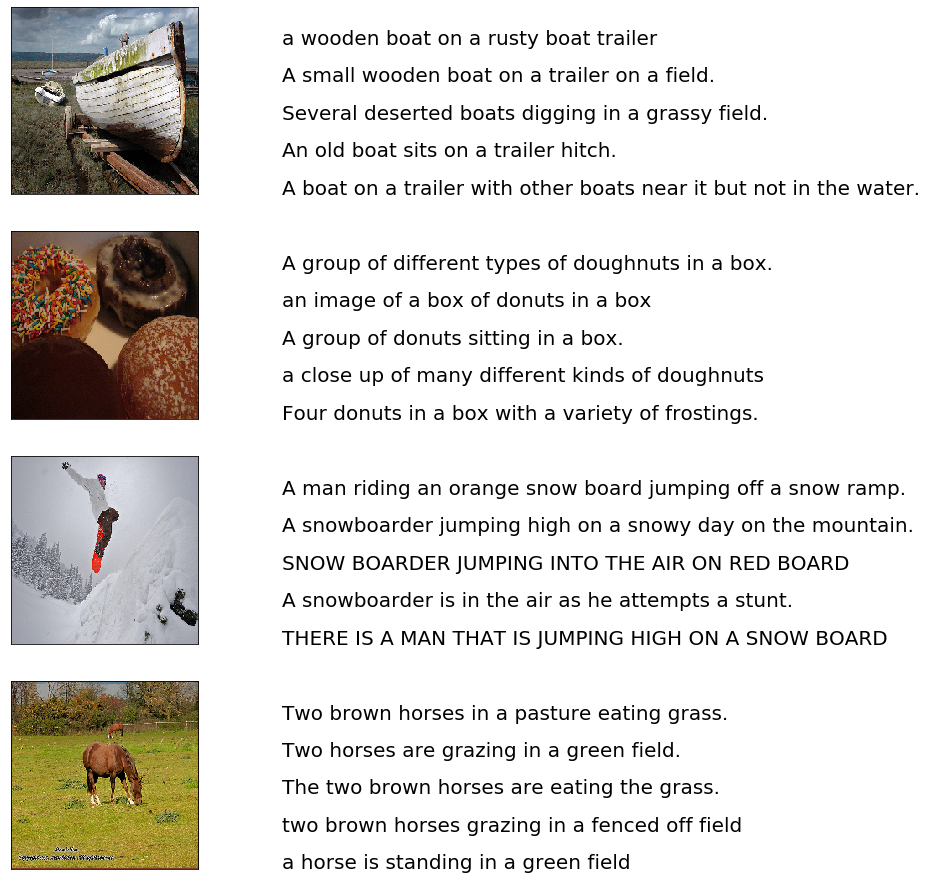

In [15]:
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from PIL import Image

npic = 5 # Displaying 5 images from the dataset
npix = 224
target_size = (npix, npix, 3)

images = 'train2017/'
count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[-4:]:
    filename = images + jpgfnm
    captions = list(df_txt["captions"].loc[df_txt["image_id"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)
    count += 1
plt.show()

## 6. Cleaning and preprocessing captions

The caption dataset contains punctuations, singular words and numerical values that need to be cleaned before it is fed to the model because uncleaned dataset will not create good captionsfor the images

In [16]:
#function to count and sort most popular words in captions available for all images
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.captions.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count", ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

In [17]:
import string

def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('', '', string.punctuation))
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word, isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [18]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

for i, caption in enumerate(df_txt.captions.values):
    newcaption = text_clean(caption)
    df_txt["captions"].iloc[i] = newcaption

Vocabulary Size: 36600


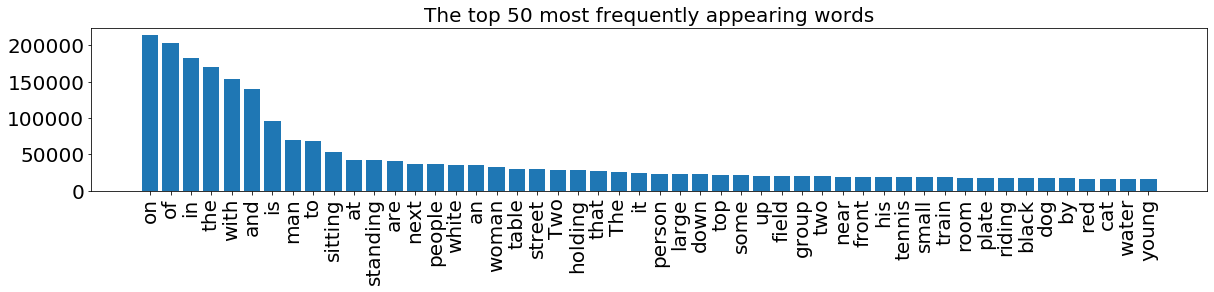

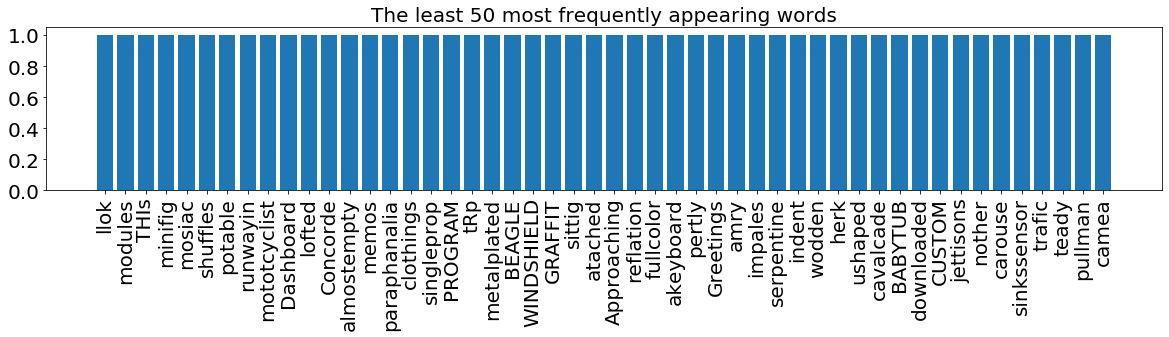

In [19]:
#plot top 50 words in clean dataset
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index, dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index, dfsub["word"], rotation=90, fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

Start and end sequence has to be added to the tokens so that it is easier to identify the captions for the images as each of them are of different length

In [20]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["captions"] = add_start_end_seq_token(df_txt["captions"])
df_txt0.head(5)
del df_txt

In [21]:
df_txt0[:5]

,id,captions,image_id
0,203564,startseq bicycle replica with clock as the fr...,000000203564.jpg
1,203564,startseq The bike has clock as tire endseq,000000203564.jpg
2,203564,startseq black metal bicycle with clock insid...,000000203564.jpg
3,203564,startseq bicycle figurine in which the front ...,000000203564.jpg
4,203564,startseq clock with the appearance of the whe...,000000203564.jpg


In [22]:
import pickle
df_txt0.to_pickle('df_txt.pickle')

## 7. Loading VGG16 model and weights to extract features from the images

This has been downloaded from the following link: https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5

In [23]:
from keras.applications import VGG16

modelvgg = VGG16(include_top=True, weights=None)

## load locally saved weights 
modelvgg.load_weights("Data/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0    

## 8. Deleting the last model layer

The last layer of the VGG-16 is excluded here because we are are just using it for extracting the features rather than using for object classification.

In [24]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)

modelvgg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## 9. Feature extraction

Here the features are extracted from all the images in the dataset. VGG-16 model gives out 4096 features from the input image of size 224 * 224

In [25]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
img_dir = 'train2017/'
images = OrderedDict()
npix = 224 #image size fixed at 224 as VGG16 model pre-trained to take that size
target_size = (npix, npix, 3)
data = np.zeros((len(jpgs), npix, npix, 3))
for i,name in enumerate(jpgs):
    # load an image from file
    filename = img_dir + name
    image = load_img(filename, target_size=target_size)
    # convert image pixels to array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

## 10. Plot similar images from the dataset

For this we have to first create a cluster and find which images belong together. Hence PCA is used to reduce the dimensions of the features which we got from VGG-16 feature extraction from 4096 to 2

First the clusters are plotted and few examples are taken from the bunch for displaying


In [26]:
from sklearn.decomposition import PCA

encoder = np.array(list(images.values()))
#print(encoder)
pca = PCA(n_components=2)
#print(pca)
y_pca = pca.fit_transform(encoder)

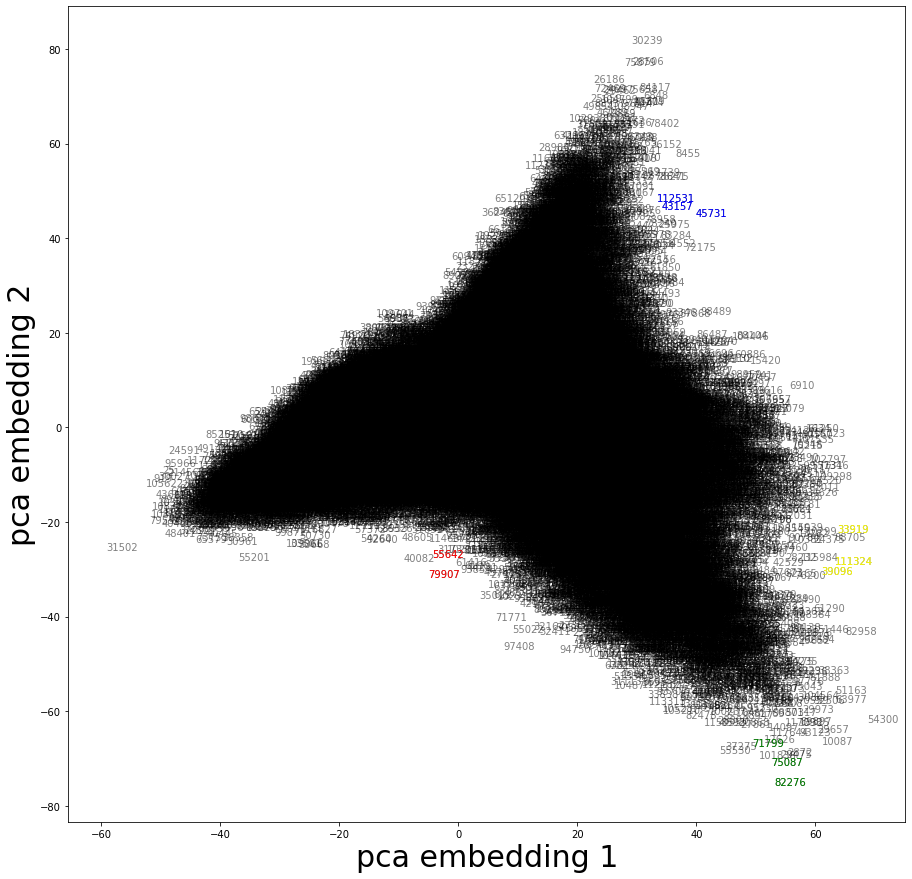

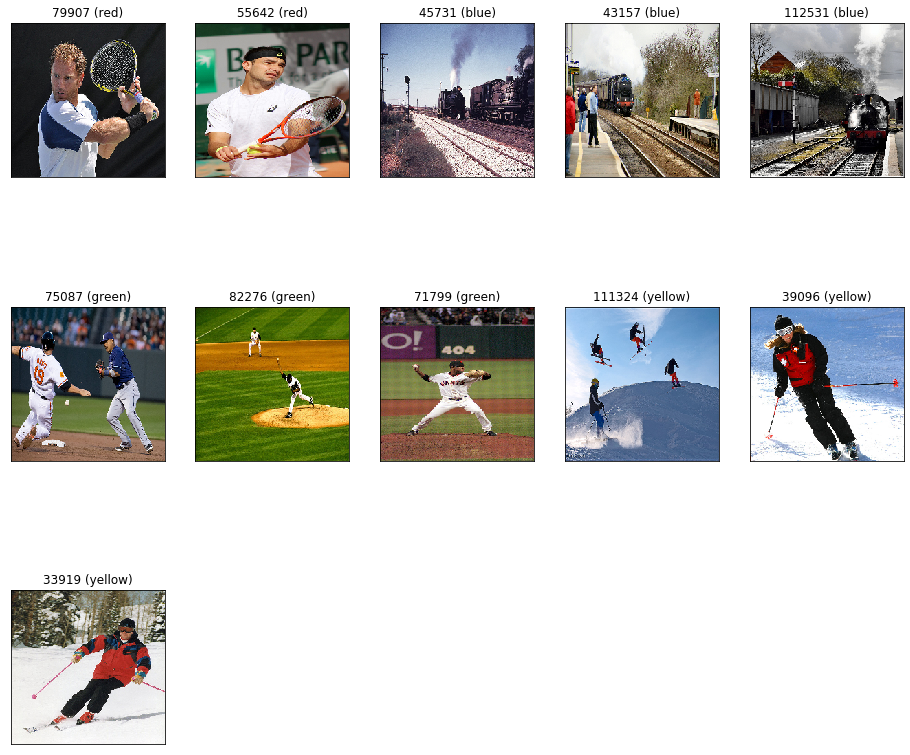

In [27]:
## some selected pictures that are creating clusters
#these are just to display the related images from the dataset
picked_pic = OrderedDict()
picked_pic["red"] = [79907,55642]
picked_pic["blue"] = [45731,43157,112531]
picked_pic["green"] = [75087,82276,71799]
picked_pic["yellow"] = [111324,39096,33919]


fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_pca[:,0], y_pca[:,1], c="white")

for irow in range(y_pca.shape[0]):
    ax.annotate(irow, y_pca[irow,:], color="black", alpha=0.5) 
for color, irows in picked_pic.items():
    for irow in irows:
        ax.annotate(irow, y_pca[irow,:], color=color)
ax.set_xlabel("pca embedding 1", fontsize=30)
ax.set_ylabel("pca embedding 2", fontsize=30)
plt.show()


## plot of images 
fig = plt.figure(figsize=(16,20))
count = 1
for color, irows in picked_pic.items():
    for ivec in irows:
        name = jpgs[ivec]
        filename = img_dir + name
        image = load_img(filename, target_size=target_size)
    
        ax = fig.add_subplot(len(picked_pic), 5, count,
                         xticks=[], yticks=[])
        count += 1
        plt.imshow(image)
        plt.title("{} ({})".format(ivec,color))
plt.show()

## 11. Merging images and captions for training

In [28]:
df_txt0 = pd.read_pickle('df_txt.pickle')

In [29]:
dimages, keepindex = [],[]

# Creating df where only first caption is taken for processing
df_txt0 = df_txt0.iloc[::5, :]
for i, fnm in enumerate(df_txt0.image_id):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)

#fnames are names of image files        
fnames = df_txt0["image_id"].iloc[keepindex].values

#dcaptions are captions of images 
dcaptions = df_txt0["captions"].iloc[keepindex].values

#dimages are actual features of images
dimages = np.array(dimages)

In [30]:
df_txt0[:5]

,id,captions,image_id
0,203564,startseq bicycle replica with clock as the fr...,000000203564.jpg
5,322141,startseq room with blue walls and white sink ...,000000322141.jpg
10,16977,startseq car that seems to be parked illegall...,000000016977.jpg
15,106140,startseq large passenger airplane flying thro...,000000106140.jpg
20,571635,startseq bathroom with toilet sink and shower...,000000571635.jpg


## 12. Tokenizing captions for further processing

As the model can't take texts as an input, they need to converted into vectors.

In [31]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 13572
[[1, 370, 3265, 7, 79, 146, 5, 37, 1065, 2], [1, 46, 7, 56, 507, 8, 17, 110, 8, 304, 2], [1, 135, 26, 1375, 10, 385, 66, 152, 66, 135, 2], [1, 27, 335, 183, 73, 94, 5, 118, 2], [1, 58, 7, 77, 110, 8, 339, 2]]


## 13. Splitting into train and test data

In [32]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts, Ntest, Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts, Ntest, Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages, Ntest, Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames, Ntest, Nval)

In [33]:
#max length of caption
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

42


## 14. Processing captions and images into required shape for the model

In [34]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [35]:
len(dt_train), len(di_train)

(70973, 70973)

In [36]:
def preprocessing(dtexts, dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) # using assert to make sure length of images and captions are similar
    Xtext, Ximage, ytext = [], [], []
    for text,image in zip(dtexts, dimages):
        # zip() is used to create a tuple of iterable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text], maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text, num_classes = vocab_size) # using to_categorical to 

            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape, Ximage.shape, ytext.shape))
    return(Xtext, Ximage, ytext)

In [37]:
Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train, di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val, di_val)
# pre-processing is not necessary for testing data

# captions/images = 70973
 (683252, 42) (683252, 4096) (683252, 13572)
# captions/images = 23657
 (226705, 42) (226705, 4096) (226705, 13572)


## 15. Building the LSTM model

In [38]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU

In [39]:
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu', name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size, dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256, name="CaptionFeature", return_sequences=True)(ftxt)
#,return_sequences=True
#,activation='relu'
se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256, name="CaptionFeature2")(se2)
## combined model for decoder
decoder = layers.add([ftxt, fimage])
decoder = layers.Dense(256, activation='relu')(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

13572
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 42)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 64)       868608      input_3[0][0]                    
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 42, 256)      328704      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 42, 256)      0           CaptionFeature[0][0]      

## 16. Training the model

In [40]:
# fit model
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=6, verbose=2, 
                  batch_size=32,
                  validation_data=([Ximage_val, Xtext_val], ytext_val), callbacks=[tensorboard])

Train on 683252 samples, validate on 226705 samples


Epoch 1/6
 - 2875s - loss: 4.1490 - val_loss: 4.1307

Epoch 2/6
 - 2775s - loss: 3.6250 - val_loss: 3.9918
Epoch 3/6
 - 2755s - loss: 3.5074 - val_loss: 3.9485
Epoch 4/6
 - 2769s - loss: 3.4494 - val_loss: 3.9337
Epoch 5/6
 - 2786s - loss: 3.4149 - val_loss: 3.9461
Epoch 6/6
 - 2786s - loss: 3.3865 - val_loss: 3.9381


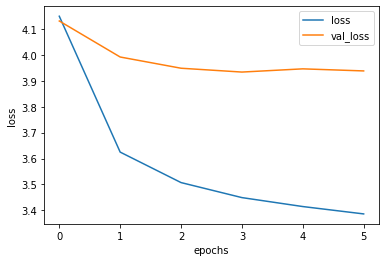

In [41]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label], label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## 17. Evaluating model performance

The model can now be tested on the test set, and evaulated on its prediction capabilities. 

In [48]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
#function to predict caption based on image input
def predict_caption(image):
    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen)
        yhat = model.predict([image, sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)

### Generating captions for whole test data and finding BLEU score

BLEU (Bilingual Evaluation Understudy) Score is a metric for evaluating a generated sentence to a reference sentence. A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

The score was developed for evaluating predictions made by automatic machine translation systems. It is not perfect, but does offer 5 compelling benefits:
+ It is quick and inexpensive to calculate.
+ It is easy to understand.
+ It is language independent.
+ It correlates highly with human evaluation.
+ It has been widely adopted.

In [49]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test, di_test, dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] 
    
    ## captions
    caption = predict_caption(image_feature.reshape(1, len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1] #remove startreg and endreg
    
    bleu = sentence_bleu([caption_true], caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu, jpgfnm, caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu, jpgfnm, caption_true, caption))

  0.85% is done..
  1.69% is done..
  2.54% is done..
  3.38% is done..
  4.23% is done..
  5.07% is done..
  5.92% is done..
  6.76% is done..
  7.61% is done..
  8.45% is done..
  9.30% is done..
  10.14% is done..
  10.99% is done..
  11.84% is done..
  12.68% is done..
  13.53% is done..
  14.37% is done..
  15.22% is done..
  16.06% is done..
  16.91% is done..
  17.75% is done..
  18.60% is done..
  19.44% is done..
  20.29% is done..
  21.14% is done..
  21.98% is done..
  22.83% is done..
  23.67% is done..
  24.52% is done..
  25.36% is done..
  26.21% is done..
  27.05% is done..
  27.90% is done..
  28.74% is done..
  29.59% is done..
  30.43% is done..
  31.28% is done..
  32.13% is done..
  32.97% is done..
  33.82% is done..
  34.66% is done..
  35.51% is done..
  36.35% is done..
  37.20% is done..
  38.04% is done..
  38.89% is done..
  39.73% is done..
  40.58% is done..
  41.43% is done..
  42.27% is done..
  43.12% is done..
  43.96% is done..
  44.81% is done..
  45

In [50]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.003


### Good and bad caption examples from the model

Using the BLEU Score, the generated caption's quality can be checked on some samples.

Examples of Bad Captions:


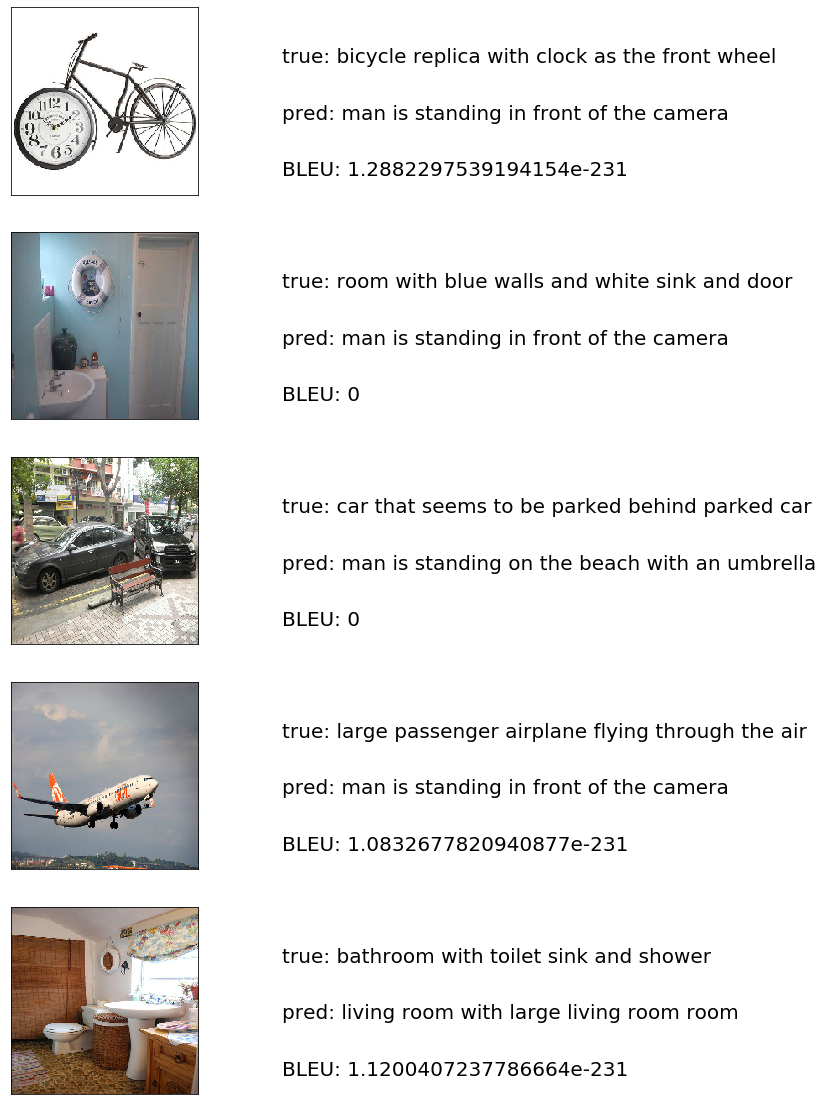

Examples of Good Captions:


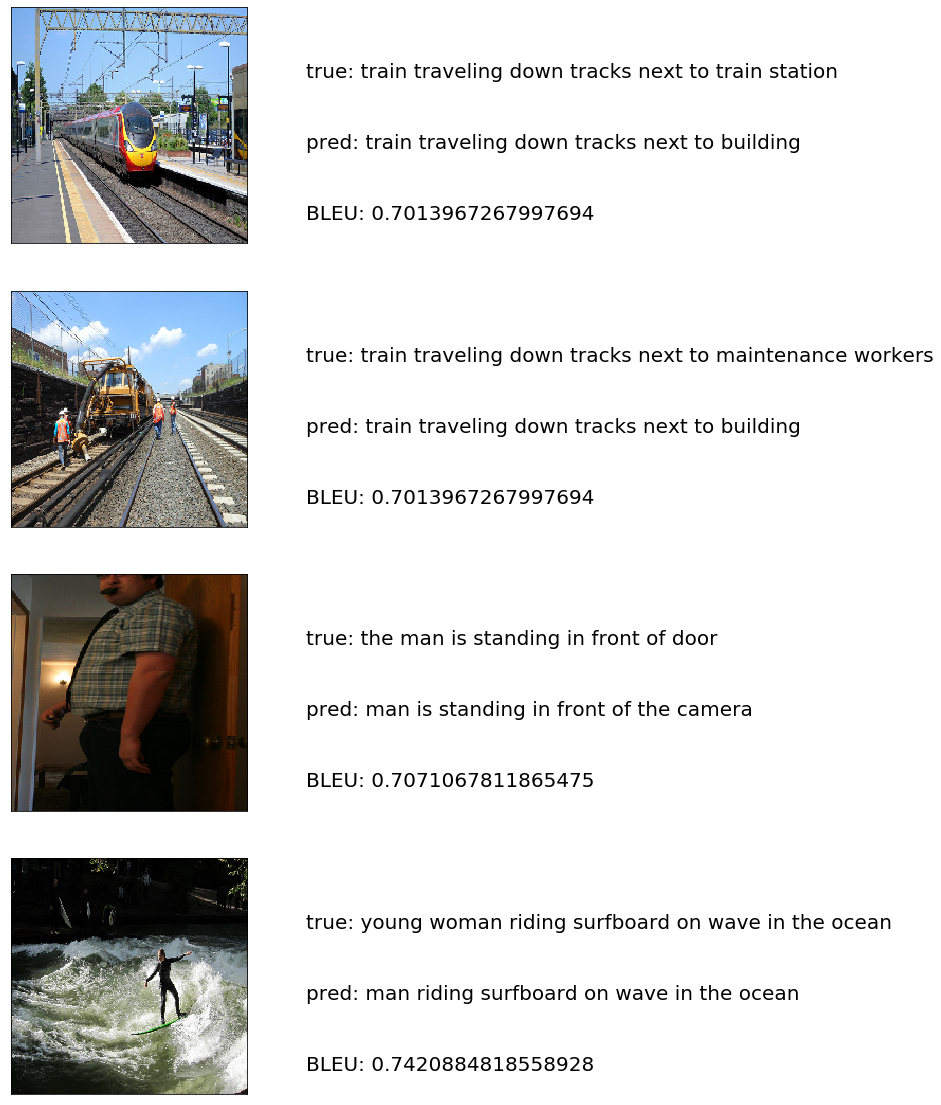

In [52]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix, npix, 3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu, jpgfnm, caption_true,caption = pb
        
        ## images 
        filename = img_dir + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true, fontsize=20)
        ax.text(0,0.4,"pred:" + caption, fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu), fontsize=20)
        count += 1
    plt.show()

print("Examples of Bad Captions:")
plot_images(pred_bad)
print("Examples of Good Captions:")
plot_images(pred_good)

This model did not perform particularly well on the test data - only achieving an average BLEU score of 0.003.

In order to improve performance, all 5 captions per picture could have been used to train the model or number of epochs could have been experimented with.